# Flight Performance Data Analysis

In this notebook, I analyzed the the [Airline On-Time Performance Data](https://www.transtats.bts.gov/Tables.asp?DB_ID=120) provided by Bureau of Transportation Statistics (BTS). This dataset includes information about on-time arrival and departure data by month and year, by carrier and by origin and destination airport. It also includes scheduled and actual departure and arrival times, canceled and diverted flights, causes of delay and cancellation, air time, and non-stop distance.
Data consists of flight performance data from 2014 and the first half of 2015 with variables such as schedule departure date & time, airline carrier, origin airport, scheduled arrival time etc. with the dependent variable of ARR_DEL_15 (a flight delayed more than 15 minutes is considered delayed).

### Data Import, Manipulation, and Exploration

In [1]:
#Import of basic libraries for data manipulation and plotting
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
from datetime import datetime, date
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [2]:
# Training files are divided into three separate files in six month increments
temp_train_2014_1 = pd.read_csv('CAX_Train_2014_Jan_to_Jun.csv')
temp_train_2014_2 = pd.read_csv('CAX_Train_2014_Jul_to_Dec.csv')
temp_train_2015 = pd.read_csv('CAX_Train_2015.csv')

# Read in the weather file
weather = pd.read_csv('weather.csv')

# The codes file is a manual matching I created between the IATA codes in the 
# training files and the ICAO codes in the weather file. Multiple IATA codes can 
# join to the same ICAO codes based on proximity to cities. City names in the 
# training files can be truncated and often did not match the weather file. 
# If the matching wasn't obvious based on the IATA and ICAO codes then IATA 
# code were looked up in Google to determine thenearest ICAO city.
codes = pd.read_csv('training_weather_cities_joined.csv')

In [3]:
# Combine all of the training files into one dataframe
training = pd.concat([temp_train_2014_1, temp_train_2014_2, temp_train_2015], ignore_index=True)

#### Additional time features are added in order to identify possible trends 

In [5]:
# Create day of year, week of year, and hour features from the flight date
training['DAY_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], 
                                         errors='coerce').dt.dayofyear.astype(int)
training['WEEK_OF_YEAR'] = pd.to_datetime(training['FL_DATE'], 
                                          errors='coerce').dt.weekofyear.astype(int)
training['hour'] = training['CRS_DEP_TIME'].map(lambda x: int(str(int(x)).zfill(4)[:2]))

In [6]:
# This array defines the dates of holidays in 2014 and 2015 which were looked up on the internet
holidays = [
        date(2014, 1, 1), date(2014, 1, 20), date(2014, 5, 26), date(2014, 7, 4),
        date(2014, 9, 1), date(2014, 11, 27), date(2014, 12, 25),
        date(2015, 1, 1), date(2015, 1, 19), date(2015, 5, 25), date(2015, 7, 4),
        date(2015, 9, 7), date(2015, 11, 26), date(2015, 12, 25)
     ]

#Function that gives the number of days from a date to the nearest holiday
def days_from_nearest_holiday(year, month, day):
  d = date(year, month, day)
  x = [(abs(d-h)).days for h in holidays]
  return min(x)

# Create the days from holiday feature using the defined function
training['days_from_holidays'] = [days_from_nearest_holiday(r.YEAR, r.MONTH, r.DAY_OF_MONTH) \
                                  for i,r in training.iterrows()]

#### Below are various charts to discover possible variables impacting flight delays.

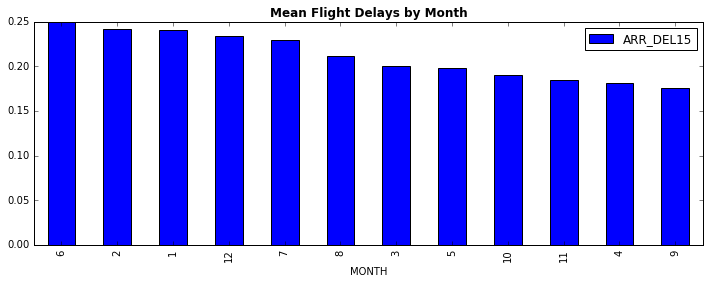

In [7]:
# Compute average number of delayed flights per month
grouped = training[['ARR_DEL15', 'MONTH']].groupby('MONTH').mean()

#Sort months from highest to lowest based on mean flight delays
grouped2 = grouped.sort(['ARR_DEL15'], ascending=False)

# plot average delays by month
grouped2.plot(kind='bar')
plt.title('Mean Flight Delays by Month', fontweight="bold")
plt.savefig('charts/delays_by_month.png')

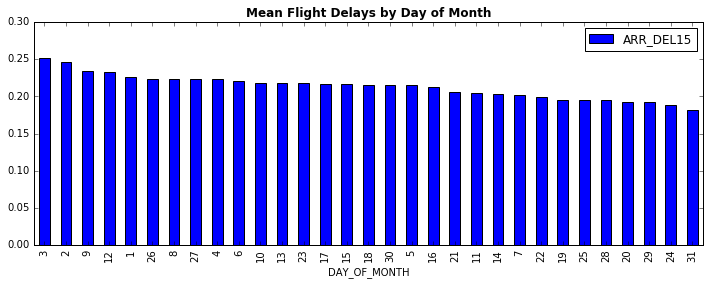

In [8]:
# Compute average number of delayed flights per day of month
grouped = training[['ARR_DEL15', 'DAY_OF_MONTH']].groupby('DAY_OF_MONTH').mean()

#Sort days from highest to lowest based on mean flight delays
grouped2 = grouped.sort(['ARR_DEL15'], ascending=False)

# plot average delays by day of month
grouped2.plot(kind='bar')
plt.title('Mean Flight Delays by Day of Month', fontweight="bold")
plt.savefig('charts/delays_by_day.png')

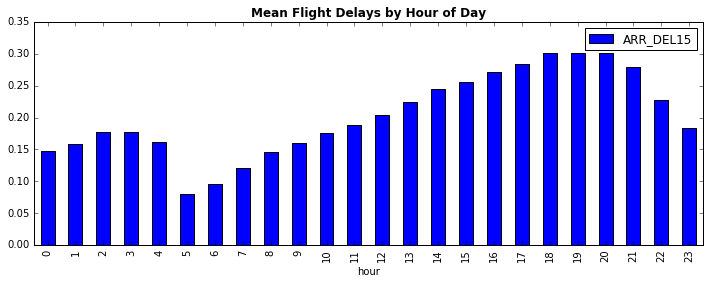

In [9]:
# Compute average number of delayed flights by hour
grouped = training[['ARR_DEL15', 'hour']].groupby('hour').mean()

# plot average delays by hour of day
grouped.plot(kind='bar')
plt.title('Mean Flight Delays by Hour of Day', fontweight="bold")
plt.savefig('charts/delays_by_hour.png')

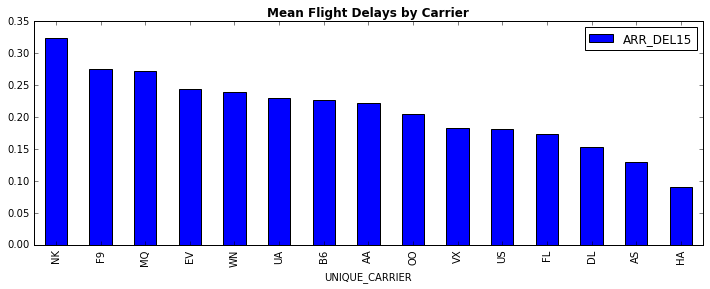

In [10]:
# Compute average number of delayed flights per carrier and filter based on carriers
# with more than 15 records
grouped = training[['ARR_DEL15', 'UNIQUE_CARRIER']] \
    .groupby('UNIQUE_CARRIER').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('UNIQUE_CARRIER').mean()

# display carriers by delay
grouped1.sort(['ARR_DEL15'], ascending=False).plot(kind='bar')
plt.title('Mean Flight Delays by Carrier', fontweight="bold")
plt.savefig('charts/delays_by_carrier.png')

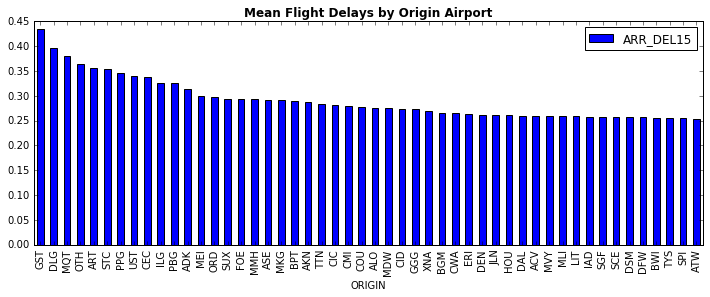

In [11]:
# Compute average number of delayed flights per origin airport based on airports
# with more than 15 records
grouped = training[['ARR_DEL15', 'ORIGIN']].groupby('ORIGIN').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('ORIGIN').mean()

# display top 50 origin airports by delay
grouped1.sort(['ARR_DEL15'], ascending=False)[:50].plot(kind='bar')
plt.title('Mean Flight Delays by Origin Airport', fontweight="bold")
plt.savefig('charts/delays_by_origin.png')

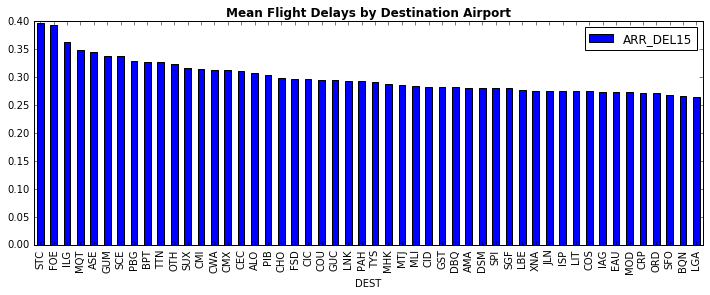

In [12]:
# Compute average number of delayed flights per destination airport
grouped = training[['ARR_DEL15', 'DEST']].groupby('DEST').filter(lambda x: len(x)>15)
grouped1 = grouped.groupby('DEST').mean()

# display top 50 origin airports by delay
grouped1.sort(['ARR_DEL15'], ascending=False)[:50].plot(kind='bar')
plt.title('Mean Flight Delays by Destination Airport', fontweight="bold")
plt.savefig('charts/delays_by_destination.png')

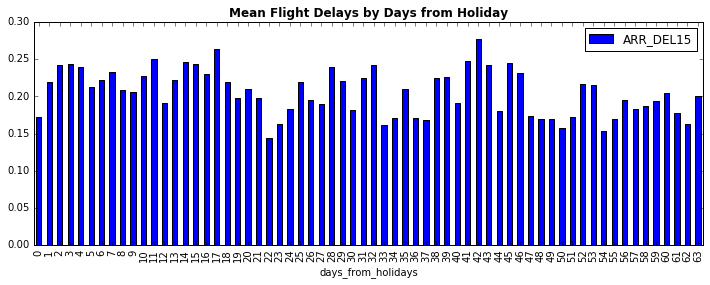

In [13]:
#Grouping days from holiday and getting the mean delay
grouped = training[['ARR_DEL15', 'days_from_holidays']].groupby('days_from_holidays').mean()

grouped.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Mean Flight Delays by Days from Holiday', fontweight="bold")
plt.savefig('charts/days_from_holiday.png')

From the above charts, it appears that some of the features have a definite impact on flight delays. 

Flights delays by hour of day dramatically increase throughout the day peaking at around 8pm. Possibly this is due to problems building on each other during the course of the day.

It's also obvious that certain carriers are more prone to delays. Origin airport appears to impact possible delays more than destination airports, but both charts start to even out quickly based on the top 50's trend.

Finally, month of year, day of month, and days from nearest holiday don't appear to have much variation when considering flight delays.